In [11]:
import sys
sys.path.insert(0, 'D:/projects/KerasFuzzy/KerasFuzzy/layers')
from defuzzy_layer_2 import DefuzzyLayer2
from defuzzy_layer import DefuzzyLayer
from fuzzy_layer_indep import FuzzyLayerIndep
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K 
import random
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
import datetime

In [12]:
dataset_etth1 = pd.read_csv("./datasets/ETTh1.csv")

column = 'OT'
dataset_etth1[column+'_n'] = (dataset_etth1[column] - dataset_etth1[column].min()) / (dataset_etth1[column].max() - dataset_etth1[column].min()) 

dataset_etth1.head()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT,OT_n
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000,0.691018
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001,0.636233
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001,0.636233
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001,0.581468
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000,0.519656


In [13]:
lookback_window = 96
forecasting_horizon = 96
input_cols = ['OT']
X = []
Y = []

for i in range(lookback_window, dataset_etth1.shape[0]- 10 * forecasting_horizon):
    X.append(dataset_etth1[input_cols].iloc[i-lookback_window:i].transpose().to_numpy()[0])
    Y.append(dataset_etth1[input_cols].iloc[i+1:i+forecasting_horizon+1].transpose().to_numpy()[0])

X_train = np.array(X)
Y_train = np.array(Y)

X = []
Y = []

for i in range(dataset_etth1.shape[0]- 10 * forecasting_horizon, dataset_etth1.shape[0]-forecasting_horizon-2):
    X.append(dataset_etth1[input_cols].iloc[i-lookback_window:i].transpose().to_numpy()[0])
    Y.append(dataset_etth1[input_cols].iloc[i+1:i+forecasting_horizon+1].transpose().to_numpy()[0])

X_val = np.array(X)
Y_val = np.array(Y)


In [14]:
model_inputs = keras.Input(shape=(lookback_window,))

x = FuzzyLayerIndep(100, min_max=[np.min(X), np.max(X)])(model_inputs)
x = layers.Dense(512)(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(128)(x)
outputs = DefuzzyLayer2(forecasting_horizon)(x)
 
model = keras.Model(model_inputs, outputs=outputs, name="ts_predictor")
model.summary()

Model: "ts_predictor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96)]              0         
                                                                 
 fuzzy_layer_indep_1 (FuzzyL  (None, 9600)             19200     
 ayerIndep)                                                      
                                                                 
 dense_2 (Dense)             (None, 512)               4915712   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               65664     
                                                                 
 defuzzy_layer2_1 (DefuzzyLa  (None, 96)               36864     
 yer2)                                                

In [15]:
batch_size = 200
epochs = 40
log_dir = "d:/projects/KerasFuzzy/logs/time_ser_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.compile(optimizer = keras.optimizers.Adam(learning_rate=2e-3), 
    loss = "mse", metrics=["mae", "mse"])


In [16]:
model.fit(X_train, Y_train, 
            batch_size = batch_size, 
            epochs = epochs, 
            validation_data = (X_val,Y_val),
            verbose = 1,  
            callbacks=[tensorboard_callback])

Epoch 1/40
82/82 [==============================] - 12s 61ms/step - loss: 103.1160 - mae: 6.7765 - mse: 103.1160 - val_loss: 7.0426 - val_mae: 1.9996 - val_mse: 7.0426
Epoch 2/40
82/82 [==============================] - 4s 44ms/step - loss: 31.9311 - mae: 3.8576 - mse: 31.9311 - val_loss: 12.8987 - val_mae: 2.5777 - val_mse: 12.8987
Epoch 3/40
82/82 [==============================] - 3s 42ms/step - loss: 20.9461 - mae: 3.2615 - mse: 20.9461 - val_loss: 7.3622 - val_mae: 2.1609 - val_mse: 7.3622
Epoch 4/40
82/82 [==============================] - 4s 44ms/step - loss: 18.2060 - mae: 2.9754 - mse: 18.2060 - val_loss: 8.8146 - val_mae: 2.3109 - val_mse: 8.8146
Epoch 5/40
82/82 [==============================] - 4s 45ms/step - loss: 16.2386 - mae: 2.7701 - mse: 16.2386 - val_loss: 10.4845 - val_mae: 2.5570 - val_mse: 10.4845
Epoch 6/40
82/82 [==============================] - 4s 45ms/step - loss: 14.6349 - mae: 2.5985 - mse: 14.6349 - val_loss: 10.0059 - val_mae: 2.4501 - val_mse: 10.0059
E

In [17]:
test_scores = model.evaluate(X_val, Y_val, verbose=2)
print("MSE:", test_scores[1])
print("MAE:", test_scores[0])

27/27 - 0s - loss: 8.6196 - mae: 2.2481 - mse: 8.6196 - 253ms/epoch - 9ms/step
MSE: 2.248075008392334
MAE: 8.619566917419434


In [18]:
pred_y = model.predict(X_val)


27/27 [==============================] - 1s 8ms/step


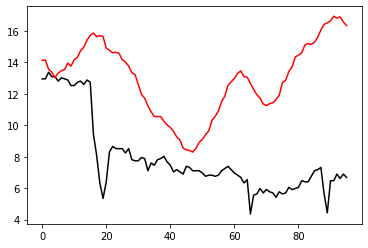

In [21]:
plt.plot(Y_val[3], c='black')
plt.plot(pred_y[3], c='red')